In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

from google.colab import drive
drive.mount('/content/gdrive')

BASE = "/content/gdrive/My Drive/input/att-database-of-faces/"

# Creating Dataframe

filepaths = []
for si in os.listdir(BASE):
    if si != 'README':
        for filename in os.listdir(BASE + si):
            filepaths.append(BASE + si + '/' + filename)
data_frame = pd.DataFrame({'filepaths': filepaths})

########################################################################################################################

# Creating the data matrix of images

images = []
for filepath in data_frame['filepaths']:
    images.append(cv2.imread(filepath, 0).flatten())
images = np.array(images)

########################################################################################################################

# labeling data with integers

n, m = images.shape
x = np.arange(1, 41)
y = np.full(40, 10)
labels = np.repeat(x, y)
images = np.column_stack((images, labels.T))

########################################################################################################################

# splitting the data for training and testing
training = images[::2, :]  # odd row
labels_training = training[:, -1]  # odd labels
testing = images[1::2, :]  # even row
labels_testing = testing[:, -1]  # even labels

########################################################################################################################

# PCA projection

alpha = np.array([0.8, 0.85, 0.9, 0.95])
mean_vector = np.mean(training[:, :-1], axis=0)
centered_matrix = training[:, :-1] - mean_vector
covariance = 1 / len(training) * np.dot(centered_matrix.T, centered_matrix)
eigen_values, eigen_vector = np.linalg.eigh(covariance)
eigen_vector = eigen_vector.T
i = eigen_values.argsort()[::-1]
eigen_values = eigen_values[i]
eigen_vector = eigen_vector[:, i]
fr = 0
r = [0, 0, 0, 0]
for i in range(len(r)):
  small_sum = 0
  while fr < alpha[i]:
    small_sum += eigen_values[r[i]]
    fr = small_sum / sum(eigen_values)
    r[i] += 1

TRAINING_PROJECTED_PCA = [] # arrays to store the projected data in each case for use in the classification with different number of neighbors
TESTING_PROJECTED_PCA = []

print("\nAccuracy for \" PCA \"")

for i in range(4):
  projection_matrix = eigen_vector[:, 0:r[i]]
  mean_vector = training[:, :-1].mean(axis=0)
  centered_matrix = training[:, :-1] - mean_vector
  training_projected = centered_matrix @ projection_matrix
  TRAINING_PROJECTED_PCA.append(training_projected)
  mean_vector = testing[:, :-1].mean(axis=0)
  centered_matrix = testing[:, :-1] - mean_vector
  testing_projected = centered_matrix @ projection_matrix
  TESTING_PROJECTED_PCA.append(testing_projected)
  prediction = KNeighborsClassifier(n_neighbors=1)
  prediction.fit(training_projected, labels_training)
  predicted = prediction.predict(testing_projected)
  accuracy = (np.sum(labels_testing == predicted) / len(labels_testing)) * 100
  print("\t when alpha = " + str(alpha[i]) + " is equal " + str(accuracy) + "%")

# print(training_projected)

# TRAINING_PROJECTED_PCA = np.array(TRAINING_PROJECTED_PCA)
# TESTING_PROJECTED_PCA = np.array(TESTING_PROJECTED_PCA)

# print(TRAINING_PROJECTED_PCA)

neighbors = [1, 3, 5, 7]

fig = plt.figure(figsize=(5,5))
fig.suptitle('accuracy for different number of neighbors')
axs = fig.add_subplot()


for n in neighbors:
  acc = []    
  print("\n \n for number of neighbours = " + str(n))
  for j in range(len(r)):
    prediction = KNeighborsClassifier(n_neighbors=n)
    prediction.fit(TRAINING_PROJECTED_PCA[j], labels_training)
    predicted = prediction.predict(TESTING_PROJECTED_PCA[j])
    accuracy = (np.sum(labels_testing == predicted) / len(labels_testing)) * 100
    axs.scatter(n, accuracy)
    # plt.plot(neighbors, accuracy)
    print("\t at alpha = " + str(alpha[j]) + " accuracy is " + str(accuracy) + "%")
    acc.append(accuracy)
  # sns.lineplot(x=neighbors, y=acc)

################################################################################################################################################################

# LDA projection

sb = 0
s = 0
mean_vector = np.mean(images[:, :-1], axis=0)

for i in range(len(np.unique(labels))):
  class_mean = np.mean(training[training[:, -1] == i+1], axis=0)  # our labels start from 1 not from 0
  class_mean = class_mean[:-1]  # remove labels from the mean vector for each class
  mean_difference = class_mean - mean_vector  # to speed up calculation of sb
  sb += len(training[training[:, -1] == i+1]) * np.outer(mean_difference, mean_difference)
  # z = training[i:i + 10, :-1] - class_mean  # not a good way of doing it
  # z = training[training[:, -1] == i+1, :-1] - class_mean # i wanna try and make this work, ask about it
  z = training[i:i + int((len(images) / len(np.unique(labels)))), :-1]
  s += z.T @ z  # NOT z @ z.T

Sinv = np.linalg.pinv(s)

eigen_values, eigen_vector = np.linalg.eigh(Sinv @ sb)
i = eigen_values.argsort()[::-1]
eigen_values = eigen_values[i]
eigen_vector = eigen_vector[:, i]
# print(eigen_vector)

projection_matrix = eigen_vector[:, 0:39]     # 0 to 39? 39 dimensions
mean_vector = training[:, :-1].mean(axis=0)
centered_matrix = training[:, :-1] - mean_vector
training_projected = centered_matrix @ projection_matrix
mean_vector = testing[:, :-1].mean(axis=0)
centered_matrix = testing[:, :-1] - mean_vector
testing_projected = centered_matrix @ projection_matrix
prediction = KNeighborsClassifier(n_neighbors=1)
prediction.fit(training_projected, labels_training)
predicted = prediction.predict(testing_projected)
accuracy = (np.sum(labels_testing == predicted) / len(labels_testing)) * 100

print("\n\n Accuracy for \" LDA \" "+str(accuracy)+"%")

neighbors = [1, 3, 5, 7]

fig = plt.figure(figsize=(5,5))
fig.suptitle('accuracy vs number of neighbors in LDA')
# axs = fig.add_subplot()

acc = []
for n in neighbors:
  prediction = KNeighborsClassifier(n_neighbors=n)
  prediction.fit(training_projected, labels_training)
  predicted = prediction.predict(testing_projected)
  accuracy = (np.sum(labels_testing == predicted) / len(labels_testing)) * 100
  # axs.scatter(n, accuracy)
  # plt.plot(neighbors, accuracy)
  print("\n for number of neighbours = " + str(n) + " accuracy is " + str(accuracy) + "%")
  acc.append(accuracy)
print("\n")
sns.lineplot(x=neighbors, y=acc)

################################################################################################################################################################
################################################################################################################################################################

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Accuracy overall for LDA 81.0%
number of success cases:  324
number of failure cases:  76
Accuracy for faces LDA 80.0%
Accuracy non-faces for LDA 82.0%

 for number of non faces  250

Accuracy overall for LDA 80.80000000000001%
number of success cases:  324
number of failure cases:  76
Accuracy for faces LDA 80.0%
Accuracy non-faces for LDA 84.0%

 for number of non faces  300

Accuracy overall for LDA 79.33333333333333%
number of success cases:  324
number of failure cases:  76
Accuracy for faces LDA 80.0%
Accuracy non-faces for LDA 78.0%

 for number of non faces  350

Accuracy overall for LDA 79.42857142857143%
number of success cases:  324
number of failure cases:  76
Accuracy for faces LDA 80.0%
Accuracy non-faces for LDA 78.66666666666666%

 for number of non faces  400

Accuracy overall for LDA 81.0%
number of success cases:  324
number of failure cases:  76
Accuracy for faces LDA 80.0%
Accuracy non-faces for LDA 82.0%


<Figure size 360x360 with 0 Axes>

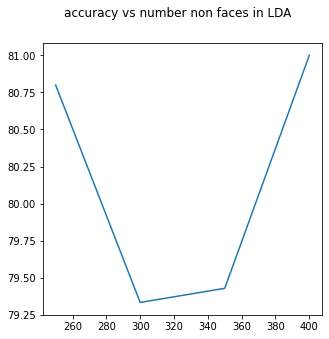

In [ ]:
# Compare vs Non-Face Images V3

BASE = "/content/gdrive/My Drive/non faces/"

# Creating Dataframe

filepaths = []
for filename in os.listdir(BASE):
  filepaths.append(BASE + '/' + filename)
data_frame = pd.DataFrame({'filepaths': filepaths})
non_faces = []
for filepath in data_frame['filepaths']:  # loading and resizing the images
  img = cv2.imread(filepath, 0)
  img = cv2.resize(img, (92, 112), interpolation=cv2.INTER_LINEAR)
  img = np.expand_dims(img, axis=0)
  non_faces.append(img.flatten())
non_faces = np.array(non_faces)
images = images[:, :-1]
images = np.vstack((images, non_faces))
labels = np.repeat([0,1], 400)  #labels column
images = np.column_stack((images, labels.T))

# splitting the data for training and testing

training = images[::2, :]  # odd row
labels_training = training[:, -1]  # odd labels
testing = images[1::2, :]  # even row
labels_testing = testing[:, -1]  # even labels

################################################################################################################################################################

# LDA non faces

sb = 0
s = 0
mean_vector = np.mean(training[:, :-1], axis=0)

for i in range(len(np.unique(labels))):
  class_mean = np.mean(training[training[:, -1] == i], axis=0)
  class_mean = class_mean[:-1]  # remove labels
  mean_difference = class_mean - mean_vector  # to speed up calculation of sb
  sb = np.outer(mean_difference, mean_difference)
  z = training[i:i + int((len(images) / len(np.unique(labels)))), :-1] - class_mean
  s += z.T @ z

Sinv = np.linalg.pinv(s)
eigen_values, eigen_vector = np.linalg.eigh(Sinv @ sb)
i = eigen_values.argsort()[::-1]
eigen_values = eigen_values[i]
eigen_vector = eigen_vector[:, i]
projection_matrix = eigen_vector[:, 0:1]
mean_vector = training[:, :-1].mean(axis=0)
centered_matrix = training[:, :-1] - mean_vector
training_projected = centered_matrix @ projection_matrix
mean_vector = testing[:, :-1].mean(axis=0)
centered_matrix = testing[:, :-1] - mean_vector
testing_projected = centered_matrix @ projection_matrix
prediction = KNeighborsClassifier(n_neighbors=1)
prediction.fit(training_projected, labels_training)
predicted = prediction.predict(testing_projected)
accuracy = (np.sum(labels_testing == predicted) / len(labels_testing)) * 100
print("Accuracy overall for LDA " + str(accuracy) + "%")

print("number of success cases: ", sum(labels_testing == predicted))
print("number of failure cases: ", 400 - sum(labels_testing == predicted))

accuracy = (np.sum(labels_testing[0:200] == predicted[0:200]) / len(labels_testing[0:200])) * 100
print("Accuracy for faces LDA " + str(accuracy) + "%")
accuracy = (np.sum(labels_testing[200:400] == predicted[200:400]) / len(labels_testing[200:400])) * 100
print("Accuracy non-faces for LDA " + str(accuracy) + "%")

fig = plt.figure(figsize=(5,5))
fig.suptitle('accuracy vs number non faces with different number of neighbors')

################################################################################################################################################################

# change number of non faces

number_of_images = [250, 300, 350, 400]
acc2 = []

for j in number_of_images:
  print("\n for number of non faces ", j)
  sb = 0
  s = 0
  mean_vector = np.mean(training[:, :-1], axis=0)

  acc = []

  for i in range(len(np.unique(labels))):
    class_mean = np.mean(training[training[:, -1] == i], axis=0)
    class_mean = class_mean[:-1]  # remove labels
    mean_difference = class_mean - mean_vector  # to speed up calculation of sb
    sb = np.outer(mean_difference, mean_difference)
    z = training[i:i + int((len(images) / len(np.unique(labels)))), :-1] - class_mean
    s += z.T @ z

  Sinv = np.linalg.pinv(s)
  eigen_values, eigen_vector = np.linalg.eigh(Sinv @ sb)
  i = eigen_values.argsort()[::-1]
  eigen_values = eigen_values[i]
  eigen_vector = eigen_vector[:, i]
  projection_matrix = eigen_vector[:, 0:1]
  mean_vector = training[:, :-1].mean(axis=0)
  centered_matrix = training[:, :-1] - mean_vector
  training_projected = centered_matrix @ projection_matrix
  mean_vector = testing[:, :-1].mean(axis=0)
  centered_matrix = testing[:, :-1] - mean_vector
  testing_projected = centered_matrix @ projection_matrix
  prediction = KNeighborsClassifier(n_neighbors=1)
  prediction.fit(training_projected, labels_training)
  predicted = prediction.predict(testing_projected)
  accuracy = (np.sum(labels_testing[0:j] == predicted[0:j]) / len(labels_testing[0:j])) * 100
  print("\nAccuracy overall for LDA " + str(accuracy) + "%")
  acc2.append(accuracy)

  print("number of success cases: ", sum(labels_testing == predicted))
  print("number of failure cases: ", 400 - sum(labels_testing == predicted))

  accuracy = (np.sum(labels_testing[0:200] == predicted[0:200]) / len(labels_testing[0:200])) * 100
  print("Accuracy for faces LDA " + str(accuracy) + "%")
  accuracy = (np.sum(labels_testing[200:j] == predicted[200:j]) / len(labels_testing[200:j])) * 100
  print("Accuracy non-faces for LDA " + str(accuracy) + "%")

  # print("\nAccuracy for \" LDA \" "+str(accuracy)+"%")

  # neighbors = [1, 3, 5, 7]

  # acc = []
  # for n in neighbors:
  #   prediction = KNeighborsClassifier(n_neighbors=n)
  #   prediction.fit(training_projected, labels_training)
  #   predicted = prediction.predict(testing_projected)
  #   accuracy = (np.sum(labels_testing == predicted) / len(labels_testing)) * 100
  #   print("\n \n for number of neighbours = " + str(n) + " accuracy is " + str(accuracy) + "%")
  #   acc.append(accuracy)
  # sns.lineplot(x=number_of_images, y=acc)

fig = plt.figure(figsize=(5,5))
fig.suptitle('accuracy vs number non faces in LDA')

sns.lineplot(x=number_of_images, y=acc2)

################################################################################################################################################################
################################################################################################################################################################

*bonus*
changed the number of instances per subject to be 7 and kept 3 instances per subject for testing

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).

Accuracy for " PCA "
	 when alpha = 0.8 is equal 86.66666666666667%
	 when alpha = 0.85 is equal 90.83333333333333%
	 when alpha = 0.9 is equal 91.66666666666666%
	 when alpha = 0.95 is equal 94.16666666666667%

 
 for number of neighbours = 1
	 at alpha = 0.8 accuracy is 86.66666666666667%
	 at alpha = 0.85 accuracy is 90.83333333333333%
	 at alpha = 0.9 accuracy is 91.66666666666666%
	 at alpha = 0.95 accuracy is 94.16666666666667%

 
 for number of neighbours = 3
	 at alpha = 0.8 accuracy is 80.0%
	 at alpha = 0.85 accuracy is 80.0%
	 at alpha = 0.9 accuracy is 82.5%
	 at alpha = 0.95 accuracy is 89.16666666666667%

 
 for number of neighbours = 5
	 at alpha = 0.8 accuracy is 74.16666666666667%
	 at alpha = 0.85 accuracy is 78.33333333333333%
	 at a

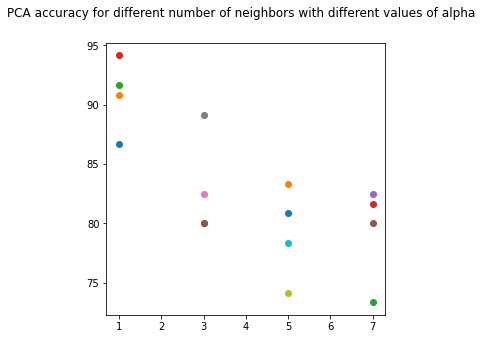

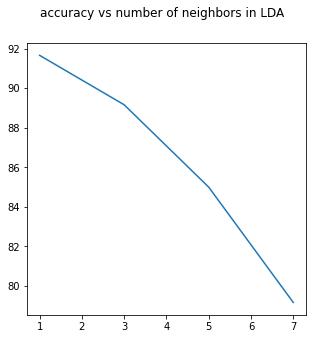

In [ ]:
# bonus

print("*bonus*\nchanged the number of instances per subject to be 7 and kept 3 instances per subject for testing\n")
# compare the results you have with the ones you got earlier with 50% split

import os
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/gdrive')

BASE = "/content/gdrive/My Drive/input/att-database-of-faces/"

# Creating Dataframe

filepaths = []
for si in os.listdir(BASE):
  if si != 'README':
    for filename in os.listdir(BASE + si):
      filepaths.append(BASE + si + '/' + filename)
data_frame = pd.DataFrame({'filepaths': filepaths})

# Creating the data matrix of images

images = []
for filepath in data_frame['filepaths']:
    images.append(cv2.imread(filepath, 0).flatten())
images = np.array(images)

# labeling data with integers

n, m = images.shape
x = np.arange(1, 41)
y = np.full(40, 10)
labels = np.repeat(x, y)
images = np.column_stack((images, labels.T))

# splitting the data for training and testing (7:3 this time)

training, testing, labels_training, labels_testing = train_test_split(images, labels, test_size=0.3)

# print("\ntraining labels\n", labels_training)

# training = []
# testing = []
# labels_training = []
# labels_testing = []

# need to adjust this loop that splits the data into training and testing sets

# for i in range(0, 400, 10):
#   print(i, "\ntraining",  images[i:i+7], "\ntesting", images[i+7:i+10])
#   training[i:i+7] = images[i:i+7, :]  # first 7 for training
#   labels_training[i:i+7] = training[i:i+7, -1]  # odd labels
#   # do we have to put the colon in the 2nd dimension to select all columns?

#   testing[i+7:i+10] = images[i+7:i+10, :]  # the remaining 3 of each 10 for testing
#   labels_testing[i+7:i+10] = testing[i+7:i+10, -1]  # even labels

# print("\ntesting labels\n", labels_testing)

# print("\nimages\n", images, "\ntraining\n", training, "\ntesting\n", testing)

# PCA projection

alpha = np.array([0.8, 0.85, 0.9, 0.95])
mean_vector = np.mean(training[:, :-1], axis=0)
centered_matrix = training[:, :-1] - mean_vector
covariance = 1 / len(training) * np.dot(centered_matrix.T, centered_matrix)
eigen_values, eigen_vector = np.linalg.eigh(covariance)
eigen_vector = eigen_vector.T
i = eigen_values.argsort()[::-1]
eigen_values = eigen_values[i]
eigen_vector = eigen_vector[:, i]
fr = 0
r = [0, 0, 0, 0]
for i in range(len(r)):
  small_sum = 0
  while fr < alpha[i]:
    small_sum += eigen_values[r[i]]
    fr = small_sum / sum(eigen_values)
    r[i] += 1

TRAINING_PROJECTED_PCA = [] # arrays to store the projected data in each case for use in the classification with different number of neighbors
TESTING_PROJECTED_PCA = []

# print("\n training labels\n", labels_training, "\ntesting labels\n", labels_testing)

print("\nAccuracy for \" PCA \"")

for i in range(4):
  projection_matrix = eigen_vector[:, 0:r[i]]
  mean_vector = training[:, :-1].mean(axis=0)
  centered_matrix = training[:, :-1] - mean_vector
  training_projected = centered_matrix @ projection_matrix
  TRAINING_PROJECTED_PCA.append(training_projected)
  # print("\n training projected \n", training_projected, "\n TRAINING_PROJECTED_PCA[i] \n", TRAINING_PROJECTED_PCA[i])
  # print("\n training labels\n", labels_training, "\ntesting labels\n", labels_testing)
  mean_vector = testing[:, :-1].mean(axis=0)
  centered_matrix = testing[:, :-1] - mean_vector
  testing_projected = centered_matrix @ projection_matrix
  TESTING_PROJECTED_PCA.append(testing_projected)
  # print("\n testing projected \n", testing_projected, "\n TESTING_PROJECTED_PCA[i] \n", TESTING_PROJECTED_PCA[i])
  # print("\n training labels\n", labels_training, "\ntesting labels\n", labels_testing)
  prediction = KNeighborsClassifier(n_neighbors=1)
  prediction.fit(training_projected, labels_training)
  predicted = prediction.predict(testing_projected)
  # print("\n testing labels\n", labels_testing, "\n predicted \n", predicted)
  accuracy = (np.sum(labels_testing == predicted) / len(labels_testing)) * 100
  print("\t when alpha = " + str(alpha[i]) + " is equal " + str(accuracy) + "%")

# print("\n TRAINING_PROJECTED_PCA \n", TRAINING_PROJECTED_PCA, "\n TESTING_PROJECTED_PCA \n", TESTING_PROJECTED_PCA)

fig = plt.figure(figsize=(5,5))
fig.suptitle('PCA accuracy for different number of neighbors with different values of alpha')
axs = fig.add_subplot()

neighbors = [1, 3, 5, 7]

for n in neighbors:
  acc = []    
  print("\n \n for number of neighbours = " + str(n))
  for j in range(len(r)):
    prediction = KNeighborsClassifier(n_neighbors=n)
    prediction.fit(TRAINING_PROJECTED_PCA[j], labels_training)
    predicted = prediction.predict(TESTING_PROJECTED_PCA[j])
    accuracy = (np.sum(labels_testing == predicted) / len(labels_testing)) * 100
    print("\t at alpha = " + str(alpha[j]) + " accuracy is " + str(accuracy) + "%")
    acc.append(accuracy)
    axs.scatter(n, accuracy)
  # sns.lineplot(x=alpha, y=acc)

# LDA projection

sb = 0
s = 0
mean_vector = np.mean(images[:, :-1], axis=0)

for i in range(len(np.unique(labels))):
  class_mean = np.mean(training[training[:, -1] == i+1], axis=0)  # our labels start from 1 not from 0
  class_mean = class_mean[:-1]  # remove labels from the mean vector for each class
  mean_difference = class_mean - mean_vector  # to speed up calculation of sb
  sb += len(training[training[:, -1] == i+1]) * np.outer(mean_difference, mean_difference)
  # z = training[i:i + 10, :-1] - class_mean  # not a good way of doing it
  # z = training[training[:, -1] == i+1, :-1] - class_mean # i wanna try and make this work, ask about it
  z = training[i:i + int((len(images) / len(np.unique(labels)))), :-1]
  s += z.T @ z  # NOT z @ z.T

Sinv = np.linalg.pinv(s)

eigen_values, eigen_vector = np.linalg.eigh(Sinv @ sb)
i = eigen_values.argsort()[::-1]
eigen_values = eigen_values[i]
eigen_vector = eigen_vector[:, i]
# print(eigen_vector)

# print("\n training set \n", training, "\n testing set \n", testing, "\n training labels \n", labels_training, "\n testing labels \n", labels_testing)

projection_matrix = eigen_vector[:, 0:39]     # 0 to 39? 39 dimensions
mean_vector = training[:, :-1].mean(axis=0)
centered_matrix = training[:, :-1] - mean_vector
training_projected = centered_matrix @ projection_matrix
mean_vector = testing[:, :-1].mean(axis=0)
centered_matrix = testing[:, :-1] - mean_vector
testing_projected = centered_matrix @ projection_matrix
prediction = KNeighborsClassifier(n_neighbors=1)
prediction.fit(training_projected, labels_training)
predicted = prediction.predict(testing_projected)
accuracy = (np.sum(labels_testing == predicted) / len(labels_testing)) * 100

print("\n\n Accuracy for \" LDA \" "+str(accuracy)+"%")

neighbors = [1, 3, 5, 7]

fig = plt.figure(figsize=(5,5))
fig.suptitle('accuracy vs number of neighbors in LDA')
# axs = fig.add_subplot()

acc = []
for n in neighbors:
  prediction = KNeighborsClassifier(n_neighbors=n)
  prediction.fit(training_projected, labels_training)
  predicted = prediction.predict(testing_projected)
  accuracy = (np.sum(labels_testing == predicted) / len(labels_testing)) * 100
  # axs.scatter(n, accuracy)
  # plt.plot(neighbors, accuracy)
  print("\n \n for number of neighbours = " + str(n) + " accuracy is " + str(accuracy) + "%")
  acc.append(accuracy)
sns.lineplot(x=neighbors, y=acc)
